# Smart Wearables -- Bonsai Tree Classification on stream data

## 1. Introduction & Library Imports 

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score
import scipy.stats as st
import sys
from sklearn.model_selection import train_test_split
from bonsai.base.regtree import RegTree
from bonsai.base.alphatree import AlphaTree
from bonsai.base.c45tree import C45Tree
from bonsai.base.ginitree import GiniTree
from bonsai.base.xgbtree import XGBTree
from bonsai.base.friedmantree import FriedmanTree
from bonsai.ensemble.randomforests import RandomForests
from bonsai.ensemble.paloboost import PaloBoost
from bonsai.ensemble.gbm import GBM
#from bonsai.ensemble.streamforests import StreamForests
import copy
import sys
import json
import time

In [ ]:
import math
from keras import optimizers
from utils import *
from model import *
from keras.utils.np_utils import to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

#import pydot
#import graphviz
#pydot.find_graphviz = lambda: True
import keras

## 2. Data Gathering

In [2]:
data_input_file = 'data/LOSO/USCHAD.npz'
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
tmp = np.load(data_input_file)
np.load = np_load_old

In [3]:
X = tmp['X']
X = X[:, 0, :, :]
y = tmp['y']
folds = tmp['folds']

In [4]:
n_class = y.shape[1]
y = np.argmax(y, axis=1)
print('Hancrafted Template 2017 {}'.format(data_input_file))

Hancrafted Template 2017 data/LOSO/USCHAD.npz


## 3. Feature Engineering

In [5]:
def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:,col])
        feat.append(average)

    return feat

def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return feat

def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return feat

def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return feat

def TBP(sample):
    from scipy import signal
    feat = []
    sum_of_time = 0
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        peaks = signal.find_peaks_cwt(data, np.arange(1,4))

        feat.append(peaks)

    return feat

def feature_extraction(X):
    #Extracts the features, as mentioned by Catal et al. 2015
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    # Time Between Peaks - TBP
    X_tmp = []
    for sample in X:
        features = A(copy.copy(sample))
        features = np.hstack((features, A(copy.copy(sample))))
        features = np.hstack((features, SD(copy.copy(sample))))
        features = np.hstack((features, AAD(copy.copy(sample))))
        features = np.hstack((features, ARA(copy.copy(sample))))
        #features = np.hstack((features, TBP(sample)))
        X_tmp.append(features)

    X = np.array(X_tmp)
    return X


## 4. RegTree

In [13]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

        #Your train goes here. For instance:
    #X_train=X_train.transpose(0,1,2).reshape(X_train.shape[0],-1)
    #X_test=X_test.transpose(0,1,2).reshape(X_test.shape[0],-1)
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = RegTree(max_depth=400,min_samples_split=1,min_samples_leaf=2)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.5207] Recall[0.6025] F1[0.4862] at fold[0]
______________________________________________________


KeyboardInterrupt: 

In [9]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.5000] IC [0.4380, 0.5620]
Mean Recall[0.4764] IC [0.4352, 0.5176]
Mean F1[0.4137] IC [0.3679, 0.4596]
Mean size[2.448]
Mean training time[1057.860]
Mean prediction time[0.184]


## 5. XGBTree

In [24]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = XGBTree(max_depth=10,min_samples_split=1,min_samples_leaf=1)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[0]
______________________________________________________
Accuracy[0.8403] Recall[0.8579] F1[0.8405] at fold[1]
______________________________________________________
Accuracy[0.9442] Recall[0.9476] F1[0.9444] at fold[2]
______________________________________________________
Accuracy[0.7820] Recall[0.7721] F1[0.7517] at fold[3]
______________________________________________________
Accuracy[0.8340] Recall[0.8406] F1[0.7990] at fold[4]
______________________________________________________
Accuracy[0.9129] Recall[0.9167] F1[0.8930] at fold[5]
______________________________________________________
Accuracy[0.8182] Recall[0.8261] F1[0.7740] at fold[6]
______________________________________________________
Accuracy[0.8452] Recall[0.8659] F1[0.8334] at fold[7]
______________________________________________________
Accuracy[0.9721] Recall[0.9716] F1[0.9711] at fold[8]
______________________________________________________
Accuracy[0.9395] Re

In [25]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.8888] IC [0.8460, 0.9317]
Mean Recall[0.8944] IC [0.8522, 0.9366]
Mean F1[0.8743] IC [0.8240, 0.9246]
Mean size[0.945]
Mean training time[1350.741]
Mean prediction time[0.123]


## 6. FriedmanTree

In [26]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = FriedmanTree(max_depth=10,min_samples_split=1,min_samples_leaf=2)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[0]
______________________________________________________
Accuracy[0.8213] Recall[0.7988] F1[0.7886] at fold[1]
______________________________________________________
Accuracy[0.8725] Recall[0.8837] F1[0.8550] at fold[2]
______________________________________________________
Accuracy[0.8534] Recall[0.8349] F1[0.8289] at fold[3]
______________________________________________________
Accuracy[0.8340] Recall[0.8406] F1[0.7986] at fold[4]
______________________________________________________
Accuracy[0.7386] Recall[0.7564] F1[0.6914] at fold[5]
______________________________________________________
Accuracy[0.9170] Recall[0.9167] F1[0.8667] at fold[6]
______________________________________________________
Accuracy[0.8410] Recall[0.8375] F1[0.8172] at fold[7]
______________________________________________________
Accuracy[0.8207] Recall[0.8288] F1[0.7986] at fold[8]
______________________________________________________
Accuracy[0.8548] Re

In [27]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.8553] IC [0.8159, 0.8948]
Mean Recall[0.8557] IC [0.8170, 0.8944]
Mean F1[0.8272] IC [0.7823, 0.8720]
Mean size[1.109]
Mean training time[1481.100]
Mean prediction time[0.107]


## 7. PaloBoost

In [28]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = PaloBoost(n_estimators=50,max_depth=6,min_samples_split=1,min_samples_leaf=2)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9843] Recall[0.9855] F1[0.9784] at fold[0]
______________________________________________________
Accuracy[0.7757] Recall[0.7557] F1[0.7250] at fold[1]
______________________________________________________
Accuracy[0.9243] Recall[0.9294] F1[0.9237] at fold[2]
______________________________________________________
Accuracy[0.8534] Recall[0.8262] F1[0.8366] at fold[3]
______________________________________________________
Accuracy[0.9170] Recall[0.9203] F1[0.9122] at fold[4]
______________________________________________________
Accuracy[0.9432] Recall[0.9291] F1[0.9334] at fold[5]
______________________________________________________
Accuracy[0.8933] Recall[0.8949] F1[0.8462] at fold[6]
______________________________________________________
Accuracy[0.7113] Recall[0.7321] F1[0.6540] at fold[7]
______________________________________________________
Accuracy[0.8008] Recall[0.7478] F1[0.7461] at fold[8]
______________________________________________________
Accuracy[0.7500] Re

In [29]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.8553] IC [0.8022, 0.9084]
Mean Recall[0.8483] IC [0.7939, 0.9028]
Mean F1[0.8238] IC [0.7571, 0.8904]
Mean size[0.211]
Mean training time[20185.270]
Mean prediction time[4.369]


## 8. GBM

In [35]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = GBM(n_estimators=50,max_depth=8)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))
    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9922] Recall[0.9928] F1[0.9924] at fold[0]
______________________________________________________
Accuracy[0.8251] Recall[0.8276] F1[0.8040] at fold[1]
______________________________________________________
Accuracy[0.9363] Recall[0.9403] F1[0.9308] at fold[2]
______________________________________________________
Accuracy[0.8872] Recall[0.8586] F1[0.8616] at fold[3]
______________________________________________________
Accuracy[0.8189] Recall[0.8261] F1[0.7874] at fold[4]
______________________________________________________
Accuracy[0.9242] Recall[0.9275] F1[0.9135] at fold[5]
______________________________________________________
Accuracy[0.9170] Recall[0.9167] F1[0.8860] at fold[6]
______________________________________________________
Accuracy[0.7448] Recall[0.7649] F1[0.7078] at fold[7]
______________________________________________________
Accuracy[0.7211] Recall[0.6742] F1[0.6438] at fold[8]
______________________________________________________
Accuracy[0.9113] Re

In [36]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.8678] IC [0.8171, 0.9185]
Mean Recall[0.8638] IC [0.8092, 0.9184]
Mean F1[0.8426] IC [0.7806, 0.9046]
Mean size[0.211]
Mean training time[41260.655]
Mean prediction time[6.397]


## 9. Conclusion

In [358]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model", "Mean Accuracy", "Mean Recall", "Mean F1"]
x.add_row(["Reg Tree", 0.8716,0.8679,0.8431])
x.add_row(["XGB Tree", 0.8888, 0.8944, 0.8743])
x.add_row(["Friedman Tree", 0.8553, 0.8532, 0.8229])
x.add_row(["Palo Boost", 0.8477, 0.8327, 0.8085])
x.add_row(["GBM", 0.8678, 0.8638, 0.8426])

y = PrettyTable()
y.field_names = ["Model", "Mean Accuracy", "Mean Recall", "Mean F1"]
y.add_row(["Mean", 86.62, 0, 0])
print(x)
print(y)

+---------------+---------------+-------------+---------+
|     Model     | Mean Accuracy | Mean Recall | Mean F1 |
+---------------+---------------+-------------+---------+
|    Reg Tree   |     0.8716    |    0.8679   |  0.8431 |
|    XGB Tree   |     0.8888    |    0.8944   |  0.8743 |
| Friedman Tree |     0.8553    |    0.8532   |  0.8229 |
|   Palo Boost  |     0.8477    |    0.8327   |  0.8085 |
|      GBM      |     0.8678    |    0.8638   |  0.8426 |
+---------------+---------------+-------------+---------+
+-------+---------------+-------------+---------+
| Model | Mean Accuracy | Mean Recall | Mean F1 |
+-------+---------------+-------------+---------+
|  Mean |     86.62     |      0      |    0    |
+-------+---------------+-------------+---------+


In [369]:
y = PrettyTable()
y.field_names = ["Model", "SNOW", "FNOW","LOTO", "LOSO"]
y.add_row(["Old paper", 90.03, 87.78, 83.41,84.52])
y.add_row(["New paper", 98.56, 97.65, 85.92,86.62])

print(y)

+-----------+-------+-------+-------+-------+
|   Model   |  SNOW |  FNOW |  LOTO |  LOSO |
+-----------+-------+-------+-------+-------+
| Old paper | 90.03 | 87.78 | 83.41 | 84.52 |
| New paper | 98.56 | 97.65 | 85.92 | 86.62 |
+-----------+-------+-------+-------+-------+


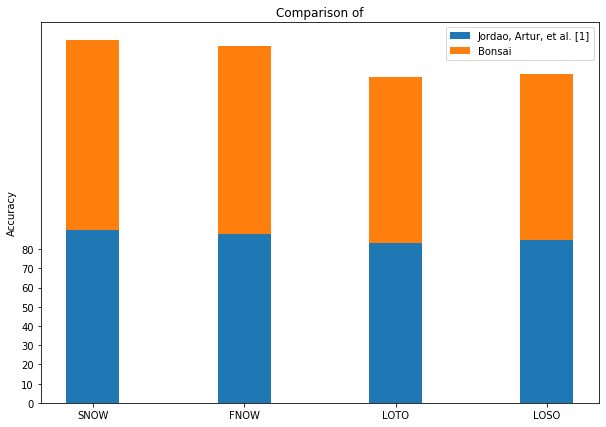

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
  
N = 4
  
boys = (90.03, 87.78, 83.41, 84.52) 
girls = (98.56, 97.65, 85.92, 86.62) 
boyStd = (2, 3, 4, 1, 2) 
girlStd = (3, 5, 2, 3, 3) 
ind = np.arange(N)    
width = 0.35  
  
fig = plt.subplots(figsize =(10, 7)) 
p1 = plt.bar(ind, boys, width)#, yerr = boyStd) 
p2 = plt.bar(ind, girls, width, 
             bottom = boys)#, yerr = girlStd) 
  
plt.ylabel('Accuracy') 
plt.title('Comparison of') 
plt.xticks(ind, ('SNOW', 'FNOW', 'LOTO', 'LOSO')) 
plt.yticks(np.arange(0, 81, 10)) 
plt.legend((p1[0], p2[0]), ('Jordao, Artur, et al. [1]', 'Bonsai')) 
  
plt.show() 

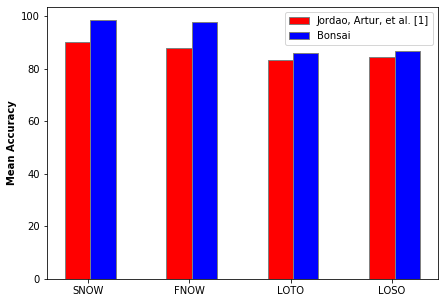

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(7, 5)) 
   
# set height of bar 
boys = [90.03, 87.78, 83.41, 84.52]
girls = [98.56, 97.65, 85.92, 86.62] 
#CSE = [29, 3, 24, 25, 17] 
   
# Set position of bar on X axis 
br1 = np.arange(4) 
br2 = [x + barWidth for x in br1] 
#br3 = [x + barWidth for x in br2] 
   
# Make the plot 
p1=plt.bar(br1, boys, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Jordao, Artur, et al. [1]') 
p2=plt.bar(br2, girls, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Bonsai') 
#plt.bar(br3, CSE, color ='b', width = barWidth, 
#        edgecolor ='grey', label ='CSE') 
   
# Adding Xticks  
plt.xlabel('', fontweight ='bold') 
plt.ylabel('Mean Accuracy', fontweight ='bold') 
plt.xticks([r + 0.1 for r in range(len(boys))], 
           ['SNOW', 'FNOW', 'LOTO', 'LOSO']) 
plt.legend((p1[0], p2[0]), ('Jordao, Artur, et al. [1]', 'Bonsai')) 
#plt.title('Comparison of Mean Accuracies with benchmark paper ') 
plt.show() 

In [22]:
#from bonsai.ensemble.streamforests import StreamForests
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

        #Your train goes here. For instance:
    #X_train=X_train.transpose(0,1,2).reshape(X_train.shape[0],-1)
    #X_test=X_test.transpose(0,1,2).reshape(X_test.shape[0],-1)
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
    reg_params = {"max_depth":10,"min_samples_split":1,"min_samples_leaf":1}
    method = StreamForests(base_estimator=XGBTree,base_params=reg_params,n_estimators=10)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[0]
______________________________________________________
Accuracy[0.8403] Recall[0.8579] F1[0.8405] at fold[1]
______________________________________________________
Accuracy[0.9442] Recall[0.9476] F1[0.9444] at fold[2]
______________________________________________________
Accuracy[0.7820] Recall[0.7721] F1[0.7517] at fold[3]
______________________________________________________
Accuracy[0.8340] Recall[0.8406] F1[0.7990] at fold[4]
______________________________________________________
Accuracy[0.9129] Recall[0.9167] F1[0.8930] at fold[5]
______________________________________________________
Accuracy[0.8182] Recall[0.8261] F1[0.7740] at fold[6]
______________________________________________________
Accuracy[0.8452] Recall[0.8659] F1[0.8334] at fold[7]
______________________________________________________
Accuracy[0.9721] Recall[0.9716] F1[0.9711] at fold[8]
______________________________________________________
Accuracy[0.9395] Re

In [23]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.8888] IC [0.8460, 0.9317]
Mean Recall[0.8944] IC [0.8522, 0.9366]
Mean F1[0.8743] IC [0.8240, 0.9246]
Mean size[0.164]
Mean training time[10734.799]
Mean prediction time[1.295]


In [21]:
class StreamForests():

    def __init__(self,
                base_estimator,
                base_params,
                n_estimators=100):
        self.base_estimator = base_estimator
        self.base_params = base_params.copy()
        self.n_estimators = n_estimators
        self.estimators = []

    def fit(self, X, y):

        X = X.astype(np.float)
        y = y.astype(np.float)
        if "random_state" not in self.base_params:
            self.base_params["random_state"] = 1
 
        bonsai_tmp = RegTree()
        bonsai_tmp.init_cnvs(X)
        xdim, cnvs, cnvsn = bonsai_tmp.get_cnvs()
        #print("hell")
        for i in range(self.n_estimators):
            self.base_params["random_state"] += 1
            estimator = self.base_estimator(**self.base_params)
            estimator.set_cnvs(xdim, cnvs, cnvsn)
            estimator.fit(X, y, init_cnvs=False)
            self.estimators.append(estimator)

    def predict(self, X):
        n, m = X.shape
        y_hat = np.zeros(n) 
        k = len(self.estimators)
        for estimator in self.estimators:
            y_hat += estimator.predict(X) 
        y_hat /= k
        return y_hat

    def dump(self, columns=[]): 
        return [estimator.dump(columns) 
                for estimator in self.estimators]
      
